<a href="https://colab.research.google.com/github/srinivas119/grainpalette---a-deep-learning-odyssey-in-rice-type-classification/blob/main/project%20files/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/project.zip -d /content/project


Streaming output truncated to the last 5000 lines.
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: /content/project/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: /content/project/Rice_Image_Dataset/K

In [18]:
from pathlib import Path

data_dir = Path('/content/project/Rice_Image_Dataset')

arborio = list(data_dir.glob('Arborio/*'))[:600]
basmati = list(data_dir.glob('Basmati/*'))[:600]
ipsala = list(data_dir.glob('Ipsala/*'))[:600]
jasmine = list(data_dir.glob('Jasmine/*'))[:600]
karacadag = list(data_dir.glob('Karacadag/*'))[:600]

# Check counts
print(len(arborio), len(basmati), len(ipsala), len(jasmine), len(karacadag))


600 600 600 600 600


In [ ]:
hii

In [19]:
import tensorflow as tf

from tensorflow import keras

# For accessing pre-trained models

import tensorflow_hub as hub

# For separating train and test sets

from sklearn.model_selection import train_test_split

# For visualizations

import matplotlib.pyplot as plt

import matplotlib.image as img

import PIL. Image as Image

import cv2

import os

import numpy as np

import pathlib

In [20]:
import pandas as pd

# Create a dictionary with image paths and their labels
image_paths = arborio + basmati + ipsala + jasmine + karacadag
labels = (['arborio'] * len(arborio) +
          ['basmati'] * len(basmati) +
          ['ipsala'] * len(ipsala) +
          ['jasmine'] * len(jasmine) +
          ['karacadag'] * len(karacadag))

# Make the DataFrame
df_images = pd.DataFrame({'path': image_paths, 'label': labels})


In [21]:
df_images['label'] = df_images['label'].astype(str).str.lower()


In [22]:
import cv2

img = cv2.imread(str(df_images[df_images['label'] == 'arborio']['path'].iloc[0]))
print(img.shape)


(250, 250, 3)


In [24]:
# Re-define label-to-index mapping
df_labels = {
    'arborio': 0,
    'basmati': 1,
    'ipsala': 2,
    'jasmine': 3,
    'karacadag': 4
}

# Now map labels to integers
df_images['label_idx'] = df_images['label'].map(df_labels)


In [25]:
import pandas as pd

# Flatten the dictionary into a list of paths and corresponding labels
image_paths = []
labels = []

for label, paths in df_images.items():
    image_paths.extend(paths)
    labels.extend([label] * len(paths))

# Create the DataFrame
df_images = pd.DataFrame({
    'path': image_paths,
    'label': labels
})

# Optional: map labels to integers using df_labels
df_images['label_idx'] = df_images['label'].map(df_labels)


In [28]:
import cv2
import numpy as np

X = []
y = []

for i, row in df_images.iterrows():
    img = cv2.imread(str(row['path']))
    if img is not None:
        img = cv2.resize(img, (128, 128))  # Resize if needed
        X.append(img)
        y.append(row['label_idx'])

# Now convert and normalize
X = np.array(X) / 255.0
y = np.array(y)


In [29]:
import numpy as np

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Normalize pixel values to [0, 1]
X = X / 255.0


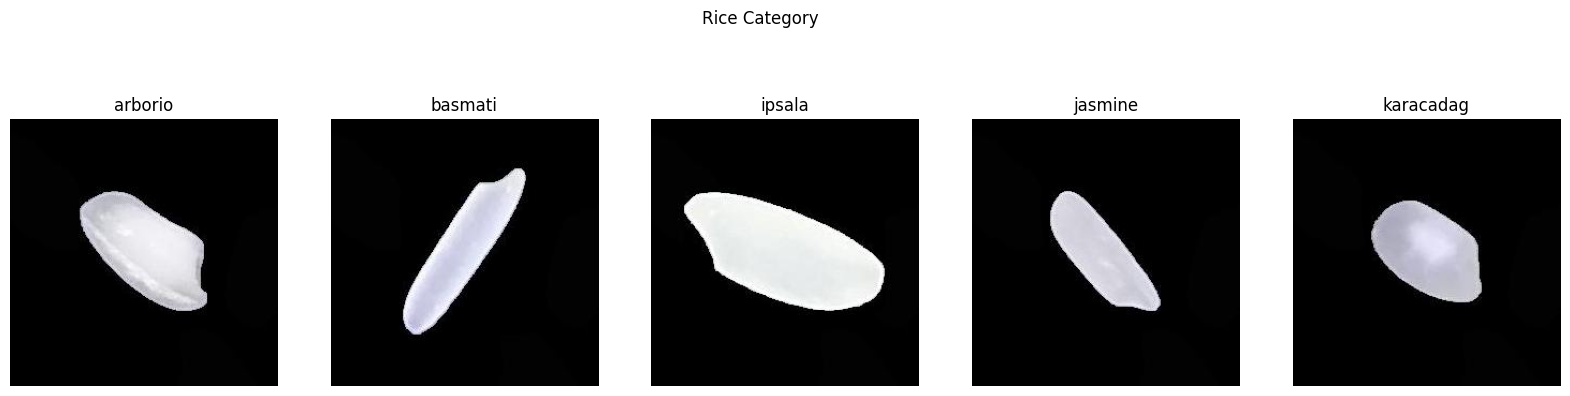

In [30]:
import matplotlib.pyplot as plt
import cv2

fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
fig.suptitle('Rice Category')

# Read one image from each category
arborio_image = cv2.imread(str(arborio[0]))
basmati_image = cv2.imread(str(basmati[0]))
ipsala_image = cv2.imread(str(ipsala[0]))
jasmine_image = cv2.imread(str(jasmine[0]))
karacadag_image = cv2.imread(str(karacadag[0]))

# Convert from BGR to RGB for correct display
images = [arborio_image, basmati_image, ipsala_image, jasmine_image, karacadag_image]
labels = ['arborio', 'basmati', 'ipsala', 'jasmine', 'karacadag']

for i in range(5):
    ax[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax[i].set_title(labels[i])
    ax[i].axis('off')

plt.show()


In [1]:
import tensorflow as tf
import tensorflow_hub as hub

# URL to MobileNetV2 feature extractor
mobile_net_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

# Load the model as a Keras layer
mobile_net_layer = hub.KerasLayer(
    mobile_net_url,
    input_shape=(224, 224, 3),
    trainable=False  # Freeze the base model
)


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

num_labels = 5

# Load the MobileNetV2 feature extractor
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    trainable=False  # don't specify input_shape here
)

# Build model with Functional API + Lambda wrapper
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda x: feature_extractor(x))(inputs)
outputs = tf.keras.layers.Dense(num_labels)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(" Model compiled successfully with Lambda wrapping.")


 Model compiled successfully with Lambda wrapping.


In [5]:
model.compile(

optimizer="adam",

loss=tf.keras.losses. SparseCategoricalCrossentropy(from_logits=True),

metrics=['acc'])

In [6]:
history model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


In [10]:
import numpy as np

# Dummy data for demonstration only
X = np.random.rand(100, 224, 224, 3).astype('float32')  # 100 images
y = np.random.randint(0, 5, size=(100,))  # 5 classes

history = model.fit(X, y, epochs=10, validation_split=0.2)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.1609 - loss: 1.8569 - val_acc: 0.2500 - val_loss: 1.6736
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - acc: 0.2477 - loss: 1.6403 - val_acc: 0.1500 - val_loss: 1.7707
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 969ms/step - acc: 0.2461 - loss: 1.7108 - val_acc: 0.2500 - val_loss: 1.6579
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 993ms/step - acc: 0.1945 - loss: 1.6607 - val_acc: 0.2000 - val_loss: 1.6369
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 0.2094 - loss: 1.6196 - val_acc: 0.2000 - val_loss: 1.6424
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 988ms/step - acc: 0.2555 - loss: 1.5968 - val_acc: 0.2500 - val_loss: 1.6518
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - acc: 0.2398 - loss: 1.5945 - val_acc: 0.2500 - val_loss: 1.6356
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - acc: 0.2430 - loss: 1.5976 - val_acc: 0.1500 - val_loss: 1.6314
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 992ms/step - acc: 0.2703 - loss: 1.5705 - val_a

In [37]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [38]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.30      0.75      0.43         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.29      0.50      0.36         4

    accuracy                           0.25        20
   macro avg       0.12      0.25      0.16        20
weighted avg       0.12      0.25      0.16        20



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [12]:
print(history.history.keys())


dict_keys(['acc', 'loss', 'val_acc', 'val_loss'])


In [29]:
import pandas as pd
import plotly.express as px

acc = pd.DataFrame({
    'train': history.history['acc'],
    'val': history.history['val_acc']
})

fig = px.line(
    acc,
    x=acc.index,
    y=['train', 'val'],
    title='Training and Validation Accuracy per Epoch',
    labels={'value': 'Accuracy', 'index': 'Epoch'}
)
fig.show()


In [34]:
import pandas as pd
import plotly.express as px

# Create loss DataFrame
loss = pd.DataFrame({
    'train': history.history['loss'],
    'val': history.history['val_loss']
})

# Plot using Plotly
fig = px.line(
    loss,
    x=loss.index,
    y=['train', 'val'],
    title='Training and Validation Loss per Epoch',
    labels={'value': 'Loss', 'index': 'Epoch'}
)

fig.show()


In [31]:
from google.colab import files
uploaded = files.upload()


Saving bas.jpeg to bas.jpeg


In [32]:
import cv2
import numpy as np

file_name = list(uploaded.keys())[0]  # Get uploaded filename
img = cv2.imread(file_name)
img = cv2.resize(img, (224, 224))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
pred = model.predict(img)
pred_class = pred.argmax()
print("Predicted class index:", pred_class)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Predicted class index: 1


In [40]:
model.save('rice.h5')


In [41]:
from google.colab import files
files.download('rice.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>